In [1]:
# Import Dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel
from sklearn.kernel_ridge import KernelRidge

### Midterm 1 Project, Problem 2-3

Optimized Kernel: 0.472**2 * ExpSineSquared(length_scale=0.398, periodicity=2.06) + WhiteKernel(noise_level=0.503)
Optimized hyperparameters:
Amplitude (α): 0.22233151956503522
Periodicity (p): 2.0633223156977243
Length Scale (ℓ): 0.3977431259514195
Noise Level (σ): 0.7095569473181922
New Noise Level (σ * 2): 1.4191138946363844


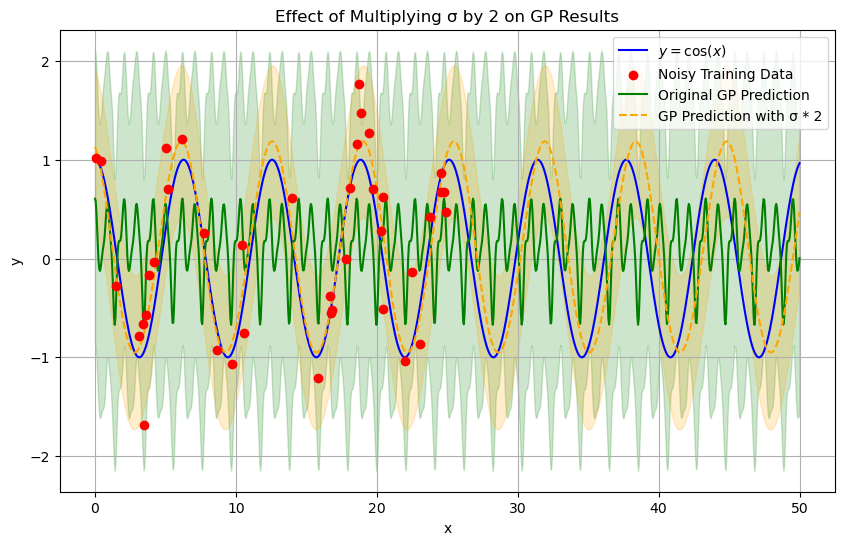

In [2]:
# Part 1: Generate noisy data as done previously
x = np.linspace(0, 50, 1000)  # Generate 1000 evenly spaced x data points
y_true = np.cos(x)  # True function y = cos(x)

# Randomly select 40 points from the first 500 data points
np.random.seed(42)  # Ensure reproducibility
indices = np.random.choice(np.arange(500), size=40, replace=False)

# Add i.i.d. random noise (mean 0, variance 0.16) to the 40 selected points
noise = np.random.normal(0, np.sqrt(0.16), size=40)
x_train = x[indices].reshape(-1, 1)  # Select 40 x points from the first 500
y_train_noisy = y_true[indices] + noise  # Add noise to the corresponding y points

# Part 2: Fit a Gaussian Process (GP) model using a periodic kernel and a white noise kernel
# Define the kernel: periodic kernel (ExpSineSquared) + white noise (WhiteKernel)
# Add a constant kernel to represent the amplitude (alpha)
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-2, 1e2)) * ExpSineSquared(length_scale=1.0, periodicity=1.0) + WhiteKernel(noise_level=1.0)

# Create the Gaussian Process Regressor with the specified kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP to the noisy data
gp.fit(x_train, y_train_noisy)

# Predict using the GP on the full x range
x_pred = x.reshape(-1, 1)
y_pred, y_std = gp.predict(x_pred, return_std=True)

# Extract the learned kernel hyperparameters
kernel_optimized = gp.kernel_
print("Optimized Kernel:", kernel_optimized)

# Extract the specific hyperparameters from the optimized kernel
alpha = kernel_optimized.k1.k1.constant_value  # Extract constant kernel value
p = kernel_optimized.k1.k2.periodicity  # Periodicity (p)
ell = kernel_optimized.k1.k2.length_scale  # Length scale (ℓ)
sigma = np.sqrt(kernel_optimized.k2.noise_level)  # Noise level (σ)

# Report the hyperparameters
print(f"Optimized hyperparameters:")
print(f"Amplitude (α): {alpha}")
print(f"Periodicity (p): {p}")
print(f"Length Scale (ℓ): {ell}")
print(f"Noise Level (σ): {sigma}")

# Part 3: Multiply the optimized σ by 2
new_sigma = 2 * sigma
print(f"New Noise Level (σ * 2): {new_sigma}")

# Update the kernel with the new noise level (σ * 2)
new_kernel = ConstantKernel(constant_value=alpha) * ExpSineSquared(length_scale=ell, periodicity=p) + WhiteKernel(noise_level=new_sigma**2)

# Re-fit the GP with the modified kernel
gp_new = GaussianProcessRegressor(kernel=new_kernel, n_restarts_optimizer=10)
gp_new.fit(x_train, y_train_noisy)

# Predict using the GP with modified noise level
y_pred_new, y_std_new = gp_new.predict(x_pred, return_std=True)

# Plot the results with the original GP and new GP after multiplying σ by 2
plt.figure(figsize=(10, 6))

# Plot the true function y = cos(x)
plt.plot(x, y_true, label=r"$y = \cos(x)$", color='blue')

# Plot the noisy training data points
plt.scatter(x_train, y_train_noisy, label="Noisy Training Data", color='red', zorder=5)

# Plot the original GP predictions with uncertainty bounds
plt.plot(x_pred, y_pred, label="Original GP Prediction", color='green')
plt.fill_between(x_pred.flatten(), y_pred - 1.96 * y_std, y_pred + 1.96 * y_std, alpha=0.2, color='green')

# Plot the new GP predictions with increased noise level
plt.plot(x_pred, y_pred_new, label="GP Prediction with σ * 2", color='orange', linestyle='--')
plt.fill_between(x_pred.flatten(), y_pred_new - 1.96 * y_std_new, y_pred_new + 1.96 * y_std_new, alpha=0.2, color='orange')

# Set labels, title, and legend
plt.title("Effect of Multiplying σ by 2 on GP Results")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
